Bartosz Klimza

#ADZD - lab 1

Przygotowanie Sparka

In [2]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 34 kB/s 
     |████████████████████████████████| 198 kB 62.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=95dca05c606bd4d6e31c82620431922c56e0f1d7765d847de94657cb163f4903
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark

In [4]:
sc = spark.sparkContext

Przygotowanie danych

In [5]:
import urllib.request
urllib.request.urlretrieve("http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs","apache_logs")
lines = sc.textFile("apache_logs")

Zadanie 1: Narysować wykres rankingu najpopularniejszych stron źródłowych (referer) z wyłączeniem domeny semicomplete.com

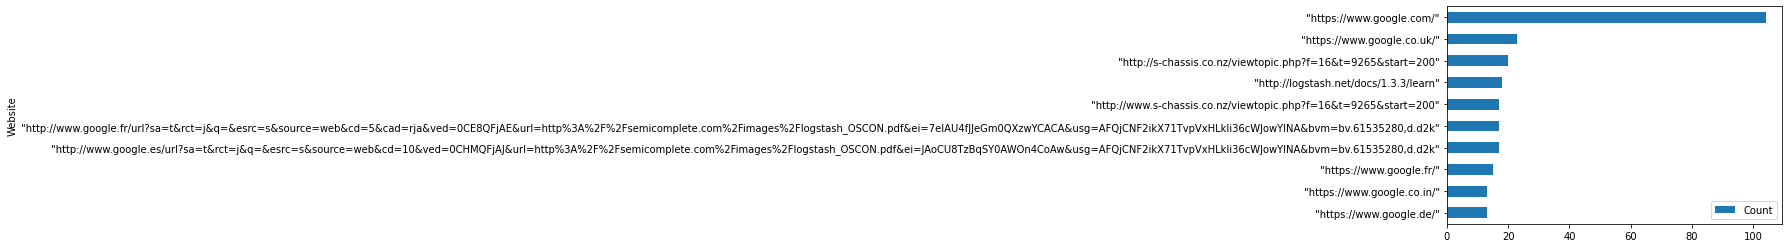

In [6]:
import re
import pandas as pd
import matplotlib.pyplot as plt
regex = "\"[^\"]*\""

def find_websites(s):
  matches = re.findall(regex, s)
  website = matches[1]
  return (website, 1)

web = lines.map(find_websites)
web_count = web.reduceByKey(lambda a, b: a + b)
top = web_count.takeOrdered(2000, lambda pair: -pair[1])

df = pd.DataFrame(top, columns=['Website', 'Count'])
m = ~df['Website'].str.contains('^"http://[www.]*semicomplete', regex=True)
df = df[m]
df = df.iloc[1:, :]
df = df.head(10)
df = df.sort_values(by=['Count'])

df.plot.barh(x = 'Website')

Na wykresie widzimy 10 najczęściej odwiedzanych adresów z wyłączeniem domeny semicomplete.com

Zadanie 2: Narysować wykres słupkowy liczby wywołań (request) na godzinę w zależności od czasu, pogrupowane po kodzie odpowiedzi (200, 404, etc):


<BarContainer object of 106 artists>

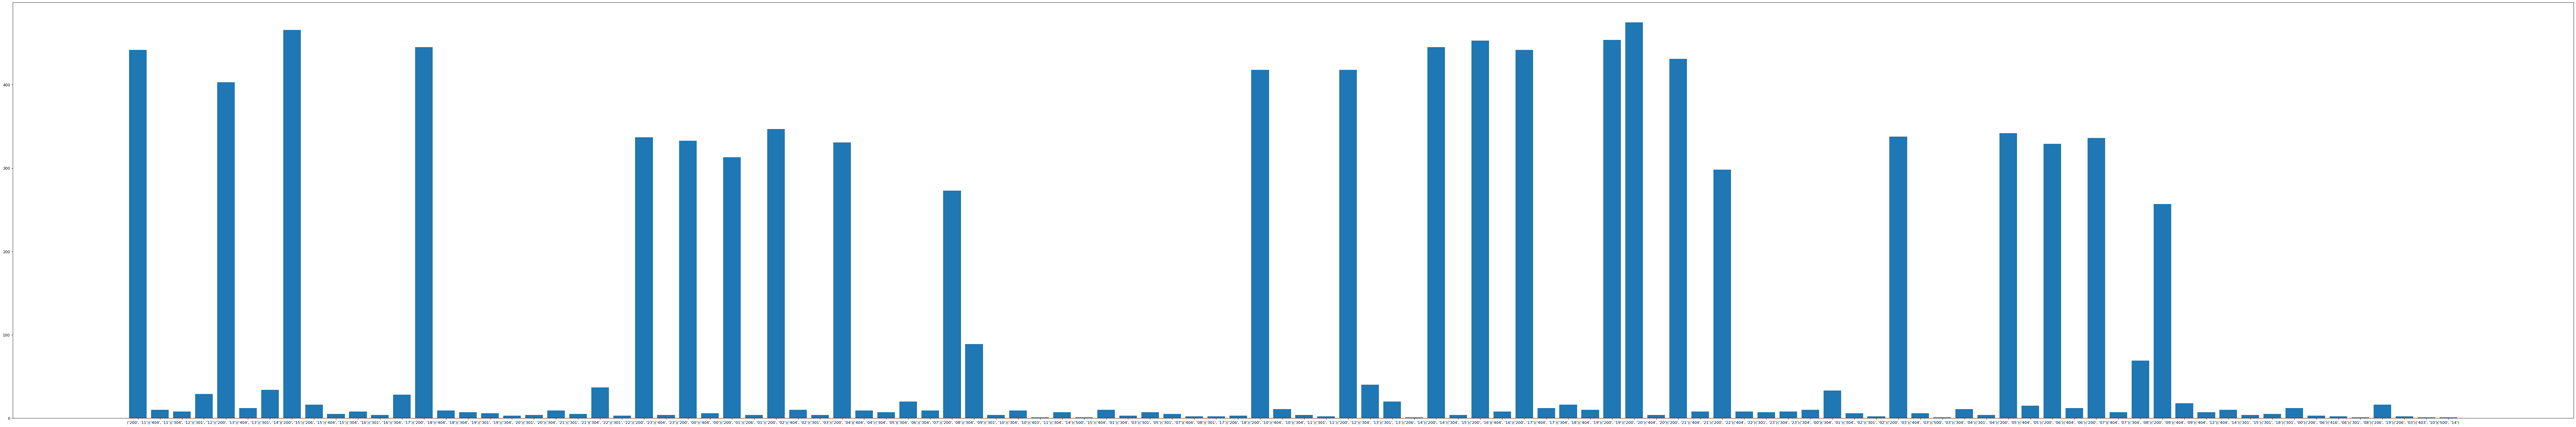

In [18]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re

date_regex = "\[.*\]"
code_regex = "(?!\".*\").*$"

def find_requests(s):
  hour_matches = re.findall(date_regex, s)
  code_matches = re.findall(code_regex, s)
  
  for_code = code_matches[0]
  code = for_code.split(sep=" ")[8]
  
  date = hour_matches[0]
  hour = date.split(sep=":")[1]

  return ((code, hour), 1)

requests = lines.map(find_requests)
requests_count = requests.reduceByKey(lambda a, b: a + b)
requests_count.collect()

requests_list = list(requests_count.collect())

requests_dict = dict()
for i in requests_list:
  requests_dict[str(i[0])] = i[1]

keys = list(requests_dict.keys())
values = list(requests_dict.values())

figure(figsize=(120, 20), dpi=80)
plt.bar(range(len(requests_dict)), values, tick_label=keys)

Powyżej pokazany został wykres przedstawiający liczbę wywołań na godzinę pogrupowane po kodzie odpowiedzi (na osi x krotki oznaczają (kod, godzinę))

Zadanie 3: Narysować wykres rankingu pobieranych zasobów według typów plików (html, css, png, etc.):

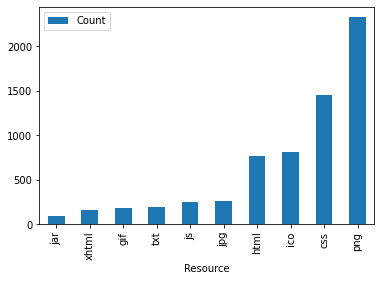

In [13]:
import re
import pandas as pd
import matplotlib.pyplot as plt

regex = "\"[^\"]*\""

def find_resources(s):
  matches = re.findall(regex, s)
  GET_section = matches[0]
  resource = GET_section[5:-10].split(sep=".")[-1]
  return (resource, 1)

web = lines.map(find_resources)
web_count = web.reduceByKey(lambda a, b: a + b)
top = web_count.takeOrdered(2000, lambda pair: -pair[1])

df = pd.DataFrame(top, columns=['Resource', 'Count'])
m = ~df['Resource'].str.contains('.*/d*', regex=True)
df = df[m]
df = df.head(10)
df = df.sort_values(by=['Count'])
df

df.plot.bar(x = 'Resource')




Na wykresie widzimy 10 najczęściej pobieranych typów zasobów

Zadanie 4: Narysować mapę z lokalizacjami klientów:

In [ ]:
!pip install https://github.com/matplotlib/basemap/archive/master.zip

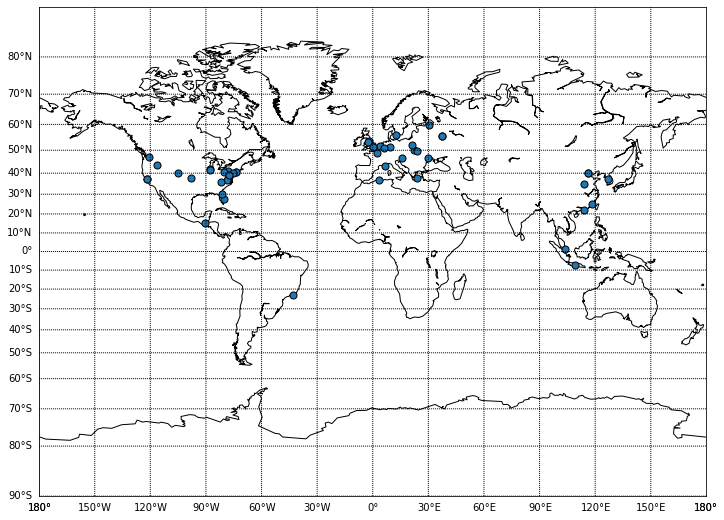

In [69]:
import requests
import re
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ip_regex = "([(\d\.)]+)"

ips = lines.map(lambda s: (re.match(ip_regex, s).group(0) ,1))
ip_count = ips.reduceByKey(lambda a, b: a + b)
ip_count.collect()

ips_list = list(ip_count.collect())
ips_dict = dict()
for i in ips_list:
  ips_dict[str(i[0])] = i[1]

keys = list(ips_dict.keys())[0:70] #Ograniczenie zbioru do 70 adresów IP 

response_dict = dict()

for i in keys:
  response = requests.get(f"https://geolocation-db.com/json/{i}&position=true").json()
  response_dict[response["latitude"]] = response["longitude"]

fig = plt.figure(figsize=(12,9))

m = Basemap(projection='mill',
           llcrnrlat = -90,
           urcrnrlat = 90,
           llcrnrlon = -180,
           urcrnrlon = 180,
           resolution = 'c')

m.drawcoastlines()

m.drawparallels(np.arange(-90,90,10),labels=[True,False,False,False])
m.drawmeridians(np.arange(-180,180,30),labels=[0,0,0,1])

sites_lat_y = list(response_dict.keys())
sites_lon_x = list(response_dict.values())

m.scatter(sites_lon_x,sites_lat_y,latlon=True, s=50, marker='o', alpha=1, edgecolor='k', linewidth=1, zorder=2)

Przedstawiłem lokalizację kilkudziesięciu klientów, ponieważ wygenerowanie mapy dla wszystkich trwa zbyt długo